# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

# Introduction

Based on my short-term research, while the Heston model defines volatility as a continuous stochastic process, GARCH provides discrete-time volatility estimates that often align more closely with real market behavior. Since this project involves simulation in discrete time, I chose to use GARCH-generated daily volatilities within a Geometric Brownian Motion (GBM) framework to simulate stock paths.

I would also like to explore using GARCH-generated volatilities within a Heston-style stock price simulation. If this were a continuous-time modeling project, I would be curious to experiment with GARCH volatilities by interpolating between daily values — for example, averaging the volatility of two consecutive days or drawing a random value between them — to approximate continuous volatility input for the Heston model. It would also be an interesting outcome to see whether such a hybrid approach integrates well with the Heston model in a continuous setting.

In [1]:
#Package Import
import yfinance as yf
from scipy.optimize import brentq
from scipy.integrate import quad
from arch import arch_model
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

/Users/gulnaragabalayeva/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/gulnaragabalayeva/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#Get Stock Data

rivn=yf.download('RIVN',period='1y', interval='1d')
rivn=rivn.dropna()
assert not rivn.empty, "Stock data not downloaded properly"



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
rivn.head(5)

Price,Close,High,Low,Open,Volume
Ticker,RIVN,RIVN,RIVN,RIVN,RIVN
Date,,,,,
2024-06-27,14.47,14.668,13.43,13.96,96798100
2024-06-28,13.42,15.120,13.21,14.49,88110300
2024-07-01,13.92,14.510,13.31,13.46,74020600
2024-07-02,14.89,15.180,13.95,14.27,88608900
2024-07-03,14.65,15.310,14.53,14.80,52620500


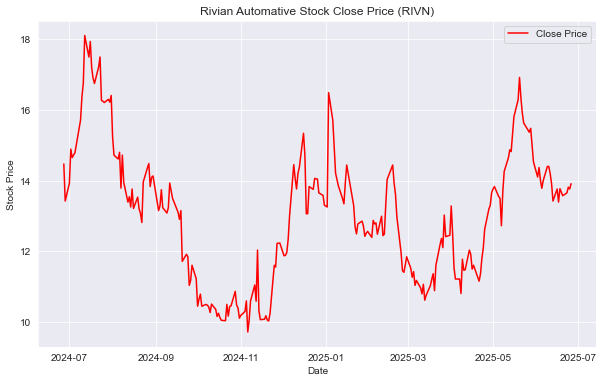

In [4]:
# Plot the stock

plt.figure(figsize=(10,6))
plt.plot(rivn['Close'], label='Close Price', color='r')
plt.title('Rivian Automative Stock Close Price (RIVN)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [5]:
#Computer Daily Log Returns

rivn['Log Return']=np.log(rivn['Close']/rivn['Close'].shift(1))
rivn.head(5)

Price,Close,High,Low,Open,Volume,Log Return
Ticker,RIVN,RIVN,RIVN,RIVN,RIVN,
Date,,,,,,
2024-06-27,14.47,14.668,13.43,13.96,96798100,NaN
2024-06-28,13.42,15.120,13.21,14.49,88110300,-0.075331
2024-07-01,13.92,14.510,13.31,13.46,74020600,0.036581
2024-07-02,14.89,15.180,13.95,14.27,88608900,0.067363
2024-07-03,14.65,15.310,14.53,14.80,52620500,-0.016250


In [6]:
# Log returns are used to model relative price changes and are additive over time
log_returns=rivn['Log Return'].dropna()
log_returns

Date
2024-06-28   -0.075331
2024-07-01    0.036581
2024-07-02    0.067363
2024-07-03   -0.016250
2024-07-05    0.009511
                ...   
2025-06-20   -0.014631
2025-06-23    0.005878
2025-06-24    0.011654
2025-06-25   -0.003627
2025-06-26    0.010842
Name: Log Return, Length: 249, dtype: float64

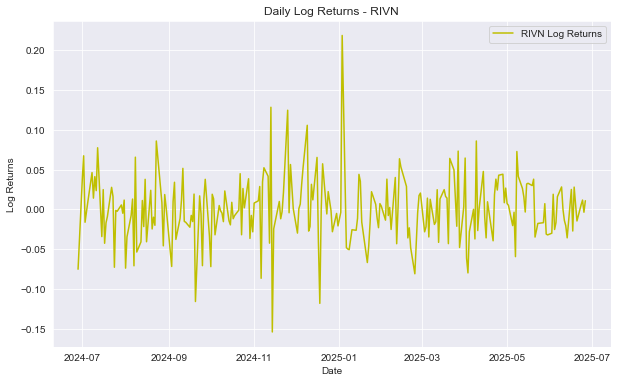

In [8]:
# Plot log returns

plt.figure(figsize=(10,6))
plt.plot(log_returns, label='RIVN Log Returns', color='y')
plt.title('Daily Log Returns - RIVN')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

The log return plot shows volatility clustering and large fluctuations, indicating non-constant variance.

This supports the use of GARCH modeling, which is designed to capture such time-varying volatility behavior.


 ### Estimate  time-varying volatility from the RIVN daily log returns using a GARCH(1,1) model.

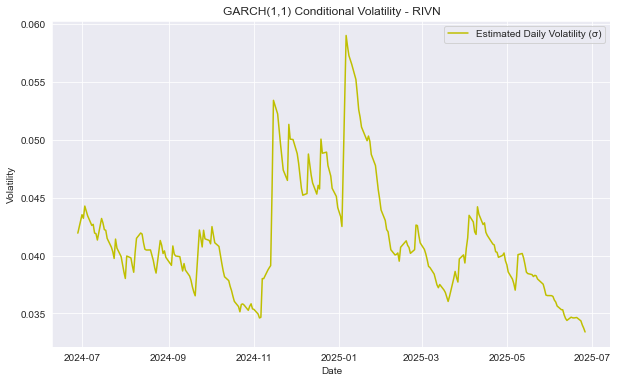

In [9]:
# Fit GARCH(1,1) model
# GARCH is sensitive to small numbers therefore we scale first
garch_model = arch_model(log_returns*1000, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Extract conditional volatility (σ_t)
# Convert back to original scale
conditional_vol = garch_fit.conditional_volatility/1000

# Plot conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(conditional_vol, color='y', label='Estimated Daily Volatility (σ)')
plt.title('GARCH(1,1) Conditional Volatility - RIVN')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [10]:
conditional_vol

Date
2024-06-28    0.041942
2024-07-01    0.043535
2024-07-02    0.043225
2024-07-03    0.044281
2024-07-05    0.043453
                ...   
2025-06-20    0.034648
2025-06-23    0.034360
2025-06-24    0.034006
2025-06-25    0.033731
2025-06-26    0.033399
Name: cond_vol, Length: 249, dtype: float64

In [11]:
conditional_vol.shape

(249,)

### Simulate Stock Paths using GARCH Volatility 

In [12]:
def stock_path_garch_sigma(S0, t, r, mu, n_paths, n_steps, sigma):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a different volatility
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    drift =(mu + r - 0.5 * sigma_matrix**2)*dt
    shock=sigma_matrix * np.sqrt(dt) * noise
    increments = drift+shock
    print(f'Mean of drift: {drift.mean()}')
    print(f'Mean of shock: {shock.mean()}')
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    print(f'Shape of the paths :{paths.shape} ')
    
    return paths
    
    

Mean of drift: 3.8832486544354444e-05
Mean of shock: 3.627679263009199e-06
Shape of the paths :(1000, 250) 


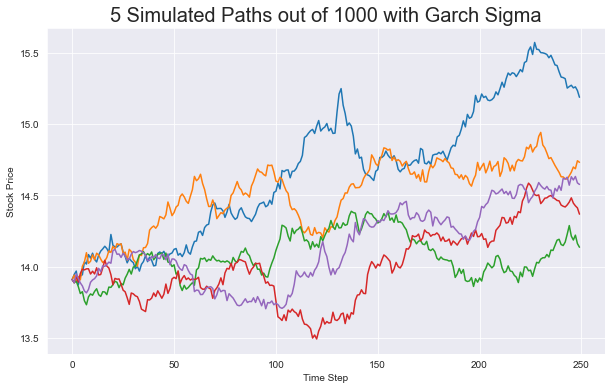

In [28]:
# Setup
S0 = rivn['Close'].iloc[-1].values[0]              # latest stock price
r = 0.05                                           # risk-free rate
mu =np.mean(log_returns)*len(conditional_vol)      # historical average annual return
n_steps = len(conditional_vol)                     # number of time steps
n_simulations = 1000                                 # number of simulated paths
t=1

# Step 1: reshape volatility correctly
sigma_t = conditional_vol.values.reshape(-1, 1).T  # shape: (n_steps, 1)

# Step 2: repeat for all simulations
sigma_matrix = np.repeat(sigma_t, n_simulations, axis=0)  # shape: (n_simulations, n_steps)


# Step 5: simulate paths
simulated_paths= stock_path_garch_sigma(S0, t,r,mu, n_simulations,n_steps,sigma_matrix)

# Now we can plot or analyze paths
plt.figure(figsize = (10,6))

for path in simulated_paths[:5,:]:
    plt.plot(path)
    
plt.title(f'5 Simulated Paths out of {n_simulations} with Garch Sigma', size = 20)
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.show()

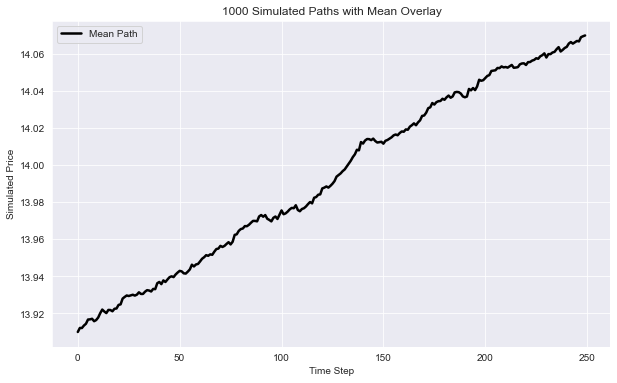

In [29]:
mean_path=simulated_paths.mean(axis=0)

plt.figure(figsize=(10,6))

# Plot the mean path on top
plt.plot(mean_path, color='black', linewidth=2.5, label='Mean Path')

plt.title(f'{n_simulations} Simulated Paths with Mean Overlay')
plt.xlabel('Time Step')
plt.ylabel('Simulated Price')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

In [31]:
# Option Parameters

K=S0
T=1


In [33]:
# Initialize a list to store portfolio values from each simulation
portfolio_values = []

# Time increment per step (in years)
dt=t/n_steps

# Loop through each simulated stock price path
for sim_i in range(n_simulations):
    path = simulated_paths[sim_i] # one full stock price path
    cash = 0                      # cash position from hedge adjustments
    delta_old = 0                 # previous delta (starting at 0)
    
    # Step through each time step in the simulation
    for step in range(n_steps):
        S_step = path[step]      # stock price at current step
        sigma_step = conditional_vol[step]  # estimated volatility from GARCH
        time_step = step * dt                # current time (in years)
        
        # Compute the Black-Scholes delta at this time step
        delta_step = bs_call_delta(S_step, K, sigma_step, T-time_step,r)
        
    
        # Adjust the hedge: buy/sell stock shares to match new delta
        # The adjustment cost is added to the cash account, discounted back to final time
        
        cash -= (delta_step - delta_old) * S_step * np.exp(r * (T - time_step))  # account for time value
        
        # Update delta for the next iteration
        delta_old = delta_step

    # At maturity, calculate the final option payoff 
    S_T = path[-1]
    
    option_payoff = np.maximum(S_T - K, 0)  # since we sold call
    
    # Final portfolio value = value of stock position - option payoff + cash
    portfolio_value = delta_old * S_T - option_payoff + cash
    
    
    portfolio_values.append(portfolio_value)
    


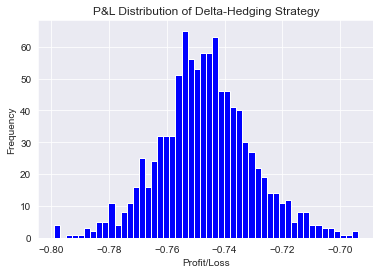

In [34]:
plt.hist(portfolio_values, bins=50, color='blue')
plt.title('P&L Distribution of Delta-Hedging Strategy')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [35]:
portfolio_mean=np.mean(portfolio_values)
portfolio_volatility=np.std(portfolio_values)

In [36]:
print(f'Mean value of the portfolio: {portfolio_mean}')
print(f'Volatility of the portfolio: {portfolio_volatility}')

Mean value of the portfolio: -0.74678087428916
Volatility of the portfolio: 0.016256223238862097


In [37]:
count =0
for x in portfolio_values:
    if x<=portfolio_mean+0.001 and x>=portfolio_mean-0.001:
        count+=1
        
        
count

54

# Observation Summary

After running the delta-hedging strategy under changing volatility (from GARCH), I see that the majority of simulations resulted in small losses. The histogram is centered around -0.74, meaning the average outcome was around a 0.74 unit loss. So even though delta hedging is supposed to protect the portfolio, it wasn’t perfect—likely because volatility wasn't constant, and we’re simulating with real-world volatility behavior.

This confirms the main idea: when volatility changes (as it realistically does), delta hedging based on constant volatility assumptions doesn’t fully protect us. It still reduces risk compared to not hedging at all, but there’s residual loss that clusters around a predictable range. The strategy is not random—it has a pattern—but it's not profit-neutral either under non-constant volatility.

# Comparison with Constant volatility case

In [38]:
sigma_const= np.std(log_returns)
sigma_const

0.04126857121912809

In [39]:
# Simulate GBM using constant volatility

Z = np.random.randn(n_simulations, n_steps)  # shape: (n_simulations, n_steps)
S_const = np.zeros((n_simulations, n_steps + 1))  # store S0 to S_n_steps
S_const[:, 0] = S0  # initial stock price

for step in range(1, n_steps + 1):
    S_const[:, step] = S_const[:, step - 1] * np.exp((r - 0.5 * sigma_const**2) * dt + sigma_const * np.sqrt(dt) * Z[:, step - 1])

print(f'Shape of the path: {S_const.shape}')  # should be (n_simulations, n_steps + 1)


Shape of the path: (1000, 250)


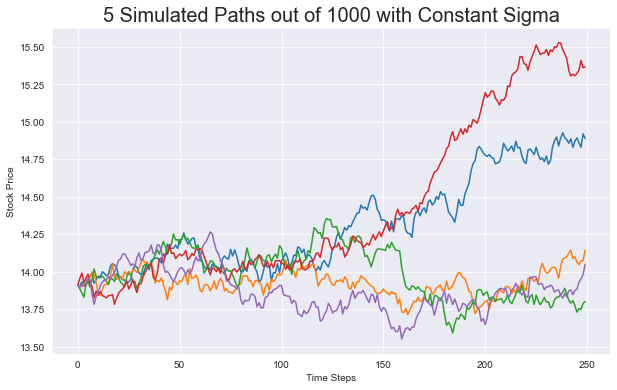

In [42]:
plt.figure(figsize = (10,6))

for path in S_const[:5,:]:
    plt.plot(path)
    
plt.title(f'5 Simulated Paths out of {n_simulations} with Constant Sigma', size = 20)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')

plt.show()

In [43]:
portfolio_pnl = []

for sim_i in range(n_simulations):
    path = S_const[sim_i]
    cash = 0
    delta_old = 0
    
    for step in range(n_steps):
        S_step = path[step]
        sigma_step = sigma_const
        time_step = step * dt
        
        # Calculate delta
        delta_step = bs_call_delta(S_step, K, sigma_step, T-time_step,r)
        
        # Buy/sell shares to match delta
        cash -= (delta_step - delta_old) * S_step * np.exp(r * (T - time_step))  # account for time value
        delta_old = delta_step

    # Final portfolio value = value of stock position - option payout + cash
    S_T = path[-1]
    option_payoff = np.maximum(S_T - K, 0)  # since we sold call
    portfolio_value = delta_old * S_T - option_payoff + cash
    portfolio_pnl.append(portfolio_value)


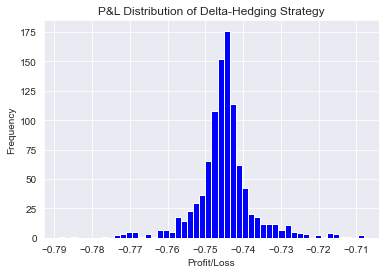

In [44]:
plt.hist(portfolio_pnl, bins=50, color='blue')
plt.title('P&L Distribution of Delta-Hedging Strategy')
plt.xlabel('Profit/Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [45]:
print(f'Mean value of the portfolio: {np.mean(portfolio_pnl)}')
print(f'Volatility of the portfolio: {np.std(portfolio_pnl)}')

Mean value of the portfolio: -0.7450553950974715
Volatility of the portfolio: 0.00800521434615525


In [47]:
count =0
for x in portfolio_pnl:
    if x<=np.mean(portfolio_pnl)+0.001 and x>=np.mean(portfolio_pnl)-0.001:
        count+=1
        
        
count

221

The standard deviation of the P&L under GARCH was approximately 0.016, nearly double that of the constant volatility case (≈ 0.008), confirming higher risk.

# Final Summary
In this mini project, I compared delta hedging performance using two approaches:

GARCH-generated volatility (non-constant)
Constant volatility based on historical standard deviation of log returns.
Both approaches yielded similar mean profit/loss (P&L) values, which confirms that delta hedging works on average — even when volatility is not constant. This supports the theoretical result that delta hedging neutralizes drift and achieves expected neutrality if volatility is modeled correctly.

In both cases, the mean portfolio profit/loss is about the same — and it's negative. So, on average, we’re losing money from the hedging strategy under both constant and GARCH scenarios. However, the spread of outcomes differs:

With constant volatility, results were tightly clustered around the mean — 221 simulations stayed close. This suggests the delta-hedging strategy was consistent and stable, offering better control and fewer surprises.
With GARCH-generated (changing) volatility, outcomes were more dispersed. Only 54 values remained close to the mean, and I observed more extreme profits and losses. Despite applying delta hedging, the fluctuating volatility led to less stable results.
The GARCH case introduces more uncertainty and risk, but also offers more upside potential. If the outcome falls on the right tail, GARCH might yield higher profits than the constant case. However, if it falls on the left, the losses can be worse.

The goal here is to reduce losses with delta hedging, and in that sense, the results are still promising: in both cases, the mean losses are around -0.76 to -0.78 cents, indicating that delta hedging helps contain risk. Even under volatility, the losses tend to stay closer to zero — which is the core objective of the strategy. Based on the empirical rule, we expect about 99% of outcomes to fall within ±3 standard deviations. That corresponds to a range of approximately -0.785 to -0.735 for the constant volatility case, and -0.829 to -0.731 for the GARCH case — confirming that while GARCH introduces greater variability, delta hedging still maintains losses within a manageable range.

# Summary for comparison

Constant volatility provides better control and predictability.
GARCH volatility brings higher real-world risk and wider dispersion — a realistic but more uncertain scenario.
Both strategies yield similar mean P&L but differ in stability.
Delta hedging theoretically works in both, but GARCH introduces a risk-reward tradeoff: potential for better gains, but also larger losses and more uncertainty.
Yet, in both cases, we observe that delta hedging helps reduce losses and keeps outcomes closer to zero — achieving the main goal of the strategy.
